In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
tf.compat.v1.enable_v2_behavior()

In [3]:
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

In [4]:
from vectorincrement import *

# Running RL with tf.agents

In [5]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}
batch_size = 64

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

In [9]:
v_n = 2
v_k = 2
v_seed = 10
do_transform = True
time_limit = 20

In [14]:
def get_env():
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [15]:
train_env = get_env()
eval_env = get_env()

In [23]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [24]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [26]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [27]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [28]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [30]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 10: Average Return = 3.0
step = 20: Average Return = 4.0
step = 25: loss = 0.13587594032287598
step = 30: Average Return = 4.0
step = 40: Average Return = 4.0
step = 50: loss = 0.3949418067932129
step = 50: Average Return = 5.0
step = 60: Average Return = 5.0
step = 70: Average Return = 5.0
step = 75: loss = 0.30179858207702637
step = 80: Average Return = 6.0
step = 90: Average Return = 6.0
step = 100: loss = 0.15299415588378906
step = 100: Average Return = 5.0
step = 110: Average Return = 5.0
step = 120: Average Return = 6.0
step = 125: loss = -0.041780948638916016
step = 130: Average Return = 6.0
step = 140: Average Return = 6.0
step = 150: loss = 0.19423985481262207
step = 150: Average Return = 7.0
step = 160: Average Return = 8.0
step = 170: Average Return = 8.0
step = 175: loss = 0.1915874481201172
step = 180: Average Return = 8.0
step = 190: Average Return = 9.0
step = 200: loss = -0.021851301193237305
step = 200: Average Return = 9.0
step = 210: Average Return = 9.0
step 

Text(0.5, 0, 'Step')

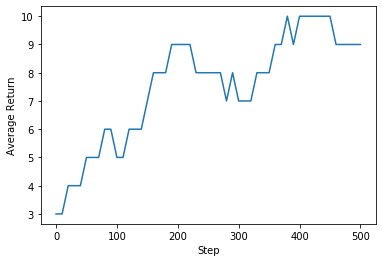

In [33]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')